# Mackey-Glass chaotic series forecasting

In this example, we will use the Wang-Mendel algorithm to forecast the Mackey-Glass chaotic series.

The idea is to use the previous N data points to predict the next one.

f($ x_0 $ ,$ x_1 $,..., $ x_N $) = $ x_{N+1} $

## Importing the modules

First of all, we are going to import the modules that will be used in this example.

Also, we are going to set the default figure size for the plots in this notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

matplotlib.rcParams['figure.figsize'] = (20, 10)

In [2]:
# Since the modules files are located in another directory,
# we need to first append this directory in the Python path
# before importing
import sys
sys.path.append("../..")

import synthetic
import membership
import rule_base
import mamdani
import wangmendel
import defuzz

## The Mackey-Glass series

Now we are going to sample 1000 points from the Mackey-Glass series and plot them.

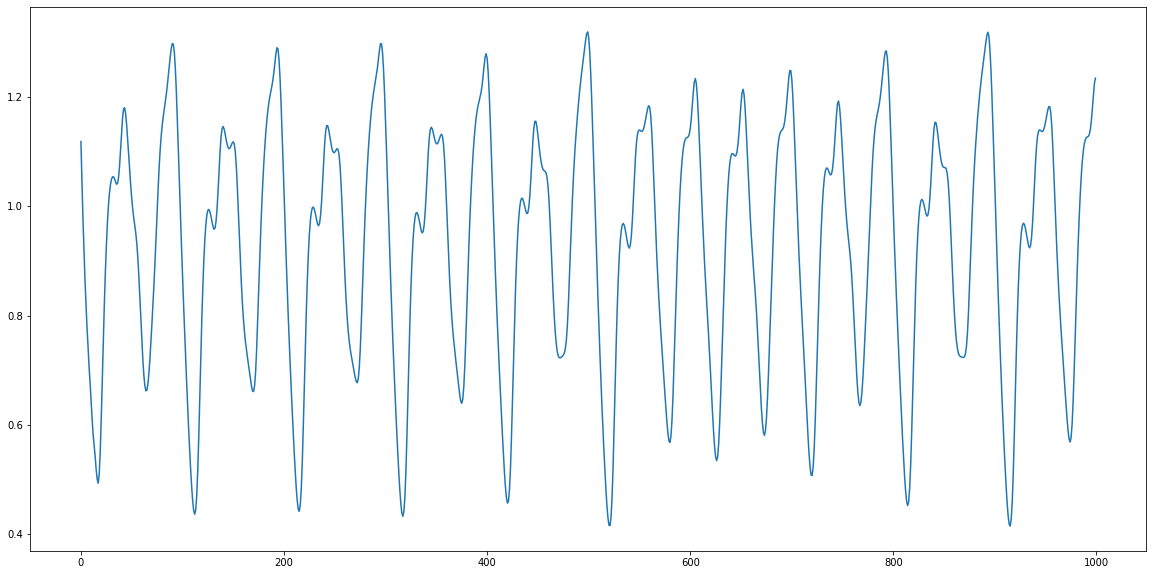

In [3]:
mg = np.ravel(synthetic.mackey_glass(sample_len=1000, tau=17)[0])

plt.plot(mg)
plt.show()

## Data preparation

Before we begin to work with the data, we need to split the series in train (ie. data that will be used to learn the fuzzy rules) and test (ie. data that will be used to evaluate the fuzzy rule base learned) sets.

For the train set we will use the first 700 data points, and for the test set the remaining 300.

In [4]:
train = mg[:700]
test = mg[700:]

print("Length of the train set: {}".format(len(train)))
print("Length of the test set: {}".format(len(test)))

Length of the train set: 700
Length of the test set: 300


Also, we need to define how many data points will be used to predict the next one and split the train and test sets in inputs and outputs.

In [5]:
N = 4

X_train, y_train, X_test, y_test = [],[],[],[]

for i in range(len(train)-(N+1)):
    X_train.append(train[i:i+N])
    y_train.append(train[i+N])    
    
for j in range(len(test)-(N+1)):
    X_test.append(test[j:j+N])
    y_test.append(test[j+N])    

To illustrate this inputs-outputs split let's look at the first elements of X_train and y_train sets.

In [6]:
print("X_train \t\t\t\t\t\t y_train")
for k in range(3):
    print("Inputs: {}\t outputs: {}".format(X_train[k], y_train[k]))
print("...")

X_train 						 y_train
Inputs: [1.11834567 1.04770478 0.97682642 0.92081908]	 outputs: 0.8656296666063084
Inputs: [1.04770478 0.97682642 0.92081908 0.86562967]	 outputs: 0.8229347076638212
Inputs: [0.97682642 0.92081908 0.86562967 0.82293471]	 outputs: 0.7776494096926926
...


## Defining the Antecedents and Consequents

The next step is to define the fuzzy regions for each of the inputs (ie. the antecedents) and for the output (ie. the consequent).

In this particular case, since all the 4 inputs and the output are points from the same series, we expect that the fuzzy regions defined for each variable to be similar.

For clarity, we will give the names 'A', 'B', 'C' and 'D' for the 4 input variables and 'E' for the output variable.

In other words, $f: A,B,C,D \rightarrow E$

To illustrate this step, let's extract the fuzzy regions for the variable $A$. We will define 6 fuzzy regions for this variable.

In [7]:
# First we will get all values of the variable A, which means the first column of the matrix X_train
A = np.array(X_train)[:,0]
print(A.shape)

(695,)


In [8]:
n_regions = 6
name_preffix = 'A'

fuzzy_regions = wangmendel.get_fuzzy_regions(A, n_regions, name_preffix)

Finally we will plot the fuzzy regions defined.

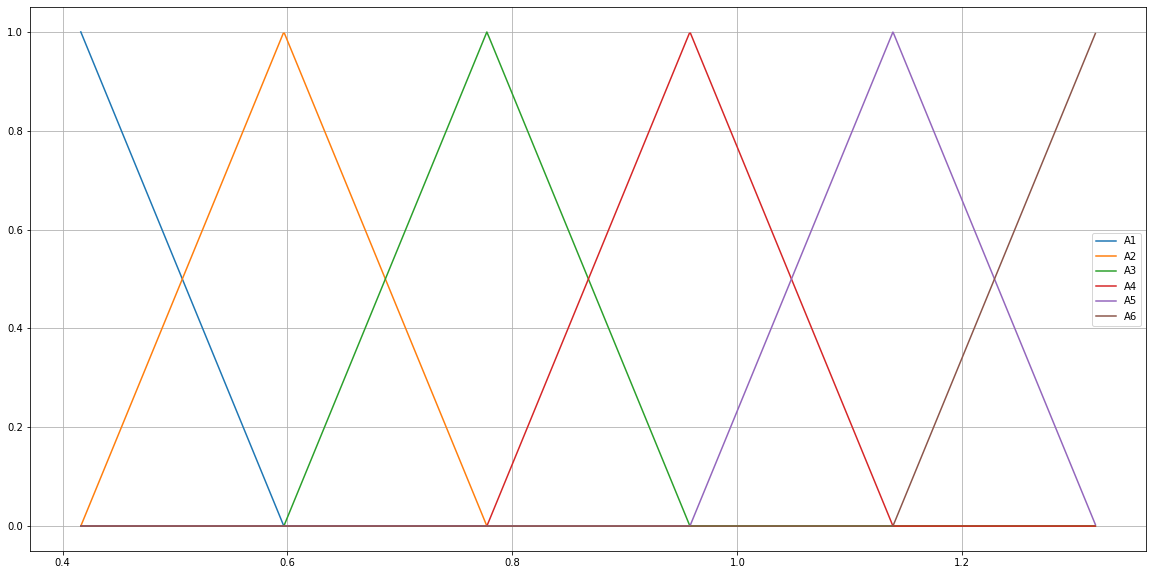

In [9]:
# First we need to define the range of values on X-axis
ini = min(A)
end = max(A)

x = np.arange(ini, end, 0.001)

for region in fuzzy_regions:
    pertinence = np.vectorize(region.set.pertinence, otypes=[float])
    plt.plot(x, pertinence(x), label=region.name)
    
plt.legend()
plt.grid()

And the membership functions of these fuzzy regions are:

In [10]:
for region in fuzzy_regions:
    print(region)

A1 = inf_border(x, 0.4162607690438249, 0.5967788149471448)
A2 = triang(x, 0.4162607690438249, 0.5967788149471448, 0.7772968608504647)
A3 = triang(x, 0.5967788149471448, 0.7772968608504647, 0.9578149067537846)
A4 = triang(x, 0.7772968608504646, 0.9578149067537844, 1.1383329526571042)
A5 = triang(x, 0.9578149067537846, 1.1383329526571044, 1.3188509985604242)
A6 = sup_border(x, 1.1383329526571044, 1.3188509985604242)


## Learning the fuzzy rules

Now we will apply the Wang-Mendel algorithm to learn the fuzzy rule base.

In [11]:
rule_base = wangmendel.learn_fuzzy_rules(X_train, y_train,
                                        n_regions_inputs=[6,6,6,6],
                                        n_regions_output=6,
                                        name_preffix_inputs=['A','B','C','D'],
                                        name_preffix_output='E')

Let's see how many fuzzy rules the algorithm has learned.

In [12]:
print("The rule base has {} rules!".format(rule_base.size()))

The rule base has 695 rules!


## Cleaning the fuzzy rule base

The next step is to clean the rule base, this means that if we has two rules with the same antecedents, we will only keep that with bigger strength.

In [13]:
rule_base = wangmendel.clean_rule_base(rule_base)
print("The cleaned rule base has {} rules!".format(rule_base.size()))

The cleaned rule base has 118 rules!


As we can see, the cleaning process eliminated a lot of conflicting rules.

## Forecasting the series

Now we will proceed to the forecasting, to do this we will use the Mamdani-Assilian inference (ie. sup-t composition).

As an example, we will predict a single data point from the test set.

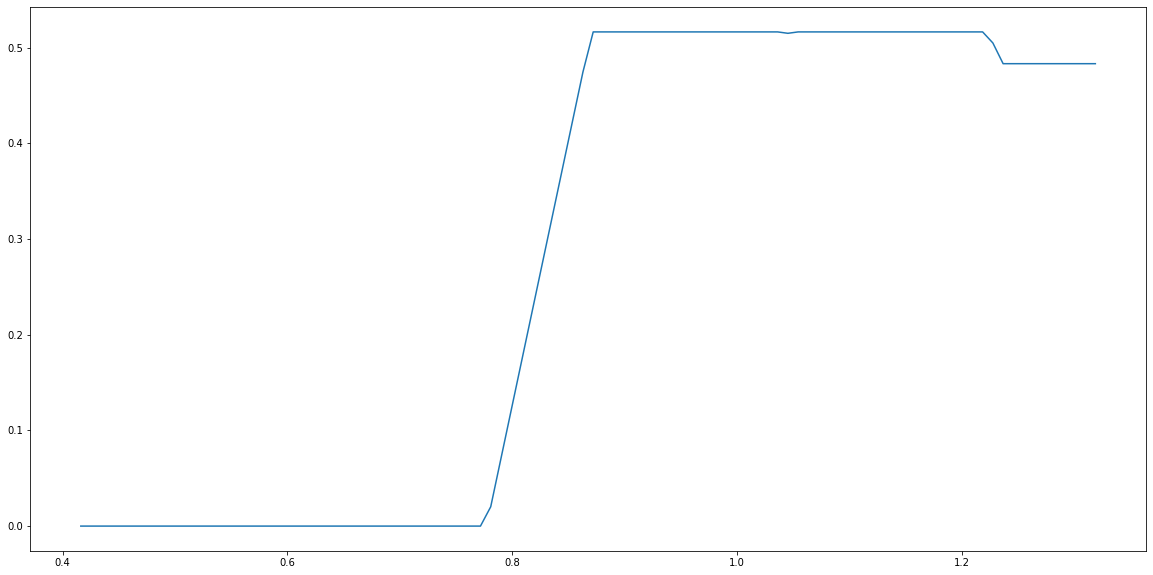

In [14]:
# The predict_crisp considers the input values as crisp sets
# and produces as output the y (domain) and f_y (image)
y, f_y = mamdani.predict_crisp(X_test[0], rule_base)
plt.plot(y, f_y)

Also, let's take a look at the true and predicted value after the centroid defuzzification.

In [15]:
print("True value: {}\n Predicted value: {}".format(y_test[0], defuzz.centroid(y, f_y)))

True value: 1.0569027297532698
 Predicted value: 1.0704144409531666


Finally, we are going to make the forecast for all points on the test set.

In [16]:
y_pred = []
for x in X_test:
    y, f_y = mamdani.predict_crisp(x, rule_base)
    y_pred.append(defuzz.centroid(y, f_y))

## Plotting and evaluating the results

To finalize this example, we will plot the forecasted along with the original series and calculate some error metrics.

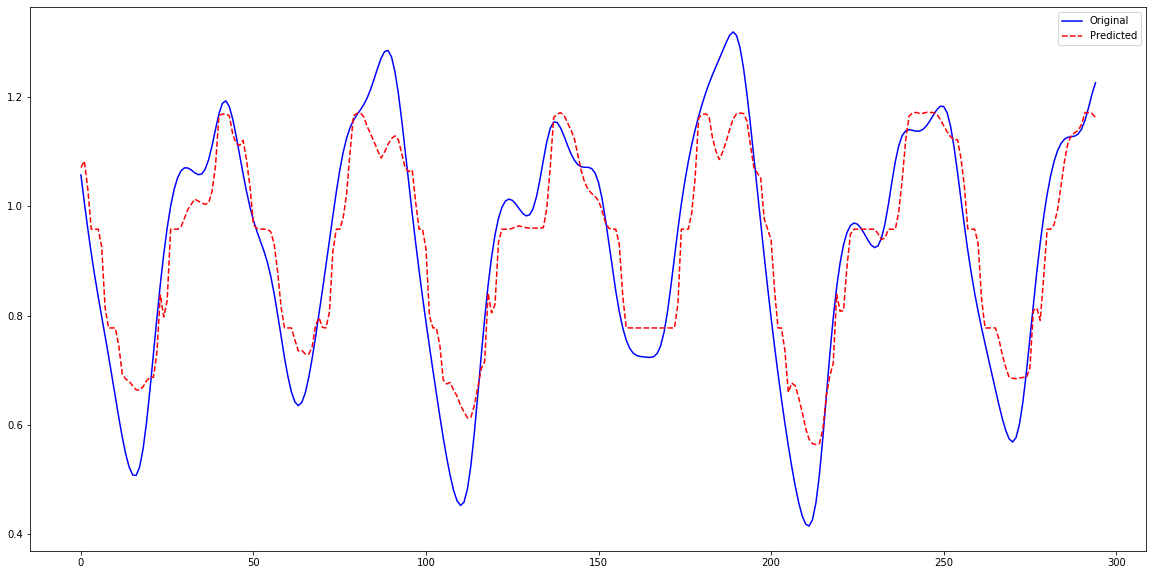

In [17]:
plt.plot(y_test, color='blue', label='Original')
plt.plot(y_pred, '--', color='red', label='Predicted')
plt.legend()

In [18]:
print("Mean squared error: {}".format(mean_squared_error(y_test, y_pred)))
print("Mean absolute error: {}".format(mean_absolute_error(y_test, y_pred)))
print("Rˆ2 (coefficient of determination): {}".format(r2_score(y_test, y_pred)))

Mean squared error: 0.00754941087151473
Mean absolute error: 0.07146725375688895
Rˆ2 (coefficient of determination): 0.8532634738093309
